In [1]:
import numpy as np
from scipy import constants
import scipy.integrate
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('text', usetex=True)
from mpmath import hyp2f1, factorial, gamma
import functools
fsc = constants.alpha
aB_in_cm = constants.value('Bohr radius') * 1e2
Ry_in_erg = constants.value('Rydberg constant times hc in J') * 1.e7  # in ergs
kb = constants.k * 1e7
h = constants.value('Planck constant') * 1e7  # in ergs s
c = constants.c * 1.e2  # in cm/s
e_e = 4.80320451e-10  # in statcoulomb
m_e = constants.electron_mass * 1e3  # in g

In [2]:
def I(eta_i, eta_f, k_i, k_f, l):
    """something dumb (radial-dipole integral)

    Arguments:
    eta_i  : modified quantum number associated with initial energy
    eta_f  : modified quantum number associated with final energy
    k_i    : wavenumber associated with initial energy
    k_f    : wavenumber associated with final energy
    l      : azimuthal quantum number

    Returns:
    I_l    : some number.
    """
    temp1 = 1 / 4 * (4. * k_i * k_f / (k_i - k_f)**2)**(l + 1)
    temp2 = np.exp(np.pi / 2 * abs(eta_i - eta_f))
    temp3 = abs(gamma(l + 1 + 1j * eta_i) *
                gamma(l + 1 + 1j * eta_f)) / gamma(2. * l + 2)
    return temp1 * temp2 * temp3 * G(eta_i, eta_f, k_i, k_f, l)


def G(eta_i, eta_f, k_i, k_f, l):
    """something dumb helper"""
    temp1 = abs((k_f - k_i) / (k_f + k_i))**(1j * eta_i + 1j * eta_f)
    temp2 = hyp2f1(l + 1 - 1j * eta_f,
                   l + 1 - 1j * eta_i,
                   2. * l + 2,
                   -4. * k_i * k_f / (k_i - k_f)**2)

    return (temp1 * temp2).real

In [3]:
def gaunt_free_free(Z, beta, E):
    """calculate the Gaunt factor for free-free emission

    Arguments:
    Z    : ion charge, int
    beta : velocity of incident electron in units of c, float or array
    E    : energy of photon in units of Ha, float or array

    Returns:
    g_ff : gaunt factor for free-free emission"""

    eta_i = Z * fsc / beta
    k_i = Z / eta_i / aB_in_cm
    eta_f = Z * fsc / (beta**2 + 2 * E * fsc**2)**.5
    k_f = Z / eta_f / aB_in_cm

    I0 = I(eta_i, eta_f, k_i, k_f, 0)
    I1 = I(eta_i, eta_f, k_i, k_f, 1)

    out = 2 * 3**.5 / np.pi / eta_i / eta_f * I0
    out *= ((eta_i**2 + eta_f**2 + 2 * eta_i**2 * eta_f**2) * I0 - 2 *
            eta_i * eta_f * (1 + eta_i**2)**.5 * (1 + eta_f**2)**.5 * I1)

    return out.real

In [4]:
def free_free_emission_spectrum(Z, hnu, E):
    """calculate free-free spectrum

    Arguments:
    Z    : ion charge, int
    hnu  : energy of emitted photon, in Ha
    E    : electron final energy, in Ha"""
    if hnu >= E:
        return 0.
    g_ff = gaunt_free_free(Z, fsc * (2 * (E - hnu))**.5, hnu)
    return 64 * np.pi**2 / 3 / 3**.5 * Z**2 * fsc**3 / (2 * E)**.5 * g_ff

The free-free emission per unit volume of a thermal gas is obtained averaging over a Maxwellian distribution, $f(E) \propto \sqrt{E} exp(-E/T)$

In [5]:
def free_free_thermal_spectrum(Z, T, E):
    """calculate free-free spectrum
    from an ensemble of electrons following a Maxwellian

    Arguments:
    Z    : ion charge, int
    T    : temperature of electrons, in Ha
    E    : energies of emitted photons, in Ha
    """
    out = np.zeros_like(E)
    for i, hnu in enumerate(E):
        out[i] = scipy.integrate.quad(
            lambda x: x**.5 * np.exp(-x / T) * free_free_emission_spectrum(Z, hnu, x), hnu, np.inf)[0]
        out[i] /= scipy.integrate.quad(lambda x: x**.5 *
                                       np.exp(-x / T), 0, np.inf)[0]
    return out

Emissivity $\epsilon_{\nu}$ of free-free emission from an ensemble of electrons therefore is proportional to the velocitiy weighted Gaunt factor.
$$\epsilon_{\nu,ff} = \frac{1}{2\pi}\frac{2^5 Z^2 e^6}{3 \sqrt{3} m^2 c^3}N_i N_e \frac{\int_{h\nu}^{\infty}g(E, \nu) e^{-E / k T} dE}{\int_{0}^{\infty}\sqrt{E} e^{-E / k T} dE} = \frac{1}{2\pi}\frac{2^5 Z^2 e^6}{3 m c^3}N_i N_e \bigg(\frac{2\pi}{3 k T m}\bigg)^{1/2} e^{-h \nu / k T} \bar{g}_{ff}$$

I am putting emissivity in cgs units.

In [73]:
def emissivity_free_free(Z, Ni, Ne, T, nu):
    """calculate emissivity of free free emission

    Arguments:
    Z    : ion charge, int
    Ni   : ion density, in cm^-3
    Ne   : electron density, in cm^-3
    T    : temperature of electrons, in K
    nu   : frequency, in Hz
    """
    T_Ha = T * 3.16680853419133e-6
    hnu_Ha = nu * 1.519828500715e-16

    term = scipy.integrate.quad(lambda x: np.exp(-x / T_Ha) * gaunt_free_free(
        Z, fsc * (2 * (x - hnu_Ha))**.5, hnu_Ha), hnu_Ha, np.inf)[0]
    term /= scipy.integrate.quad(lambda x: x**.5 *
                                 np.exp(-x / T_Ha), 0, np.inf)[0]
    # the exponential is folded into the numerator

    prefactor = 2**5 * np.pi * Z**2 * e_e**6 / 3 / m_e / c**3
    temp2 = (2 * np.pi / 3 / kb / m_e / T)**.5
    return prefactor * temp2 * term

In [7]:
test = []
for nu in np.logspace(np.log10(3e13), np.log10(3e15), 200):
    test.append(nu * emissivity_free_free(1, 1, 1, 10000, nu))

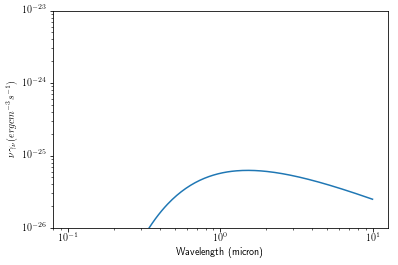

In [8]:
plt.loglog(3e14 / np.logspace(np.log10(3e13), np.log10(3e15), 200),
           1 / 2 / np.pi * np.array(test))
plt.ylim(1e-26, 1e-23)
plt.ylabel(r'\nu \gamma_{\nu} (erg cm^{-3}s^{-1})')
plt.xlabel('Wavelength (micron)')

In [9]:
def G_l(l, m, eta, rho):
    """G matrix element, radial-dipole integral"""
    gl = 0
    for i in range(2 * m + 1):
        gl += b_s(i, l, m, eta, rho) * rho**i

    return gl


@functools.lru_cache(maxsize=1024)
def b_s(s, l, m, eta, rho):
    """polynomial solution to matrix element G_l"""
    if s == 0:
        return 1
    if s == 1:
        return 2 * m * eta / l

    bsminus1 = b_s(s - 1, l, m, eta, rho)
    bsminus2 = b_s(s - 2, l, m, eta, rho)
    bs = -(1 / (s * (s + 2 * l - 1))) * (4 * eta * (s - 1 - m) *
                                         bsminus1 + (2 * m + 2. - s) * (2 * m + 2 * l + 1 - s) * bsminus2)
    return bs

In [10]:
def sigma_minus(n, l, E, Z):
    """Cross section for bound-free absorption from (n, l) through
    dipole transition to E with angular momentum l-1"""
    eta = (Z**2 * Ry_in_erg / E)**.5
    nu = E / h
    if l == 0:
        return 0

    rho = eta / n
    GlA = G_l(l, -(l + 1 - n), eta, rho)
    GlB = G_l(l, -(l - 1 - n), eta, rho)

    prefactor = 2**(4 * l) / 3 * np.pi * e_e**2 / m_e / c / nu

    A = 1
    for l_i in range(1, l):
        A *= (l_i**2 + eta**2)
    B = l**2 * factorial(n + l) / factorial(2 * l + 1) / \
        factorial(2 * l - 1) / factorial(n - l - 1)
    C = np.exp(-4 * eta * np.arctan2(1, rho)) / (1 - np.exp(-2 * np.pi * eta))
    D = rho**(2 * l + 2) / (1 + rho**2)**(2 * n - 2)
    E = (GlA - (1 + rho**2)**(-2) * GlB)**2
    return prefactor * A * B * C * D * E


def sigma_plus(n, l, E, Z):
    """Cross section for bound-free absorption from (n, l) through
    dipole transition to E with angular momentum l+1"""
    eta = (Z**2 * Ry_in_erg / E)**.5
    rho = eta / n
    nu = E / h
    GlA = G_l(l + 1, -(l + 1 - n), eta, rho)
    GlB = G_l(l + 1, -(l - n), eta, rho)

    prefactor = 2**(4 * l + 6) / 3 * np.pi * e_e**2 / m_e / c / nu

    A = 1
    for l_i in range(l + 1):
        A *= ((l_i + 1)**2 + eta**2)
    B = (l + 1)**2 * factorial(n + l) / (2 * l + 1) / factorial(2 * l + 1) / \
        factorial(2 * l + 2) / factorial(n - l - 1) / ((l + 1)**2 + eta**2)**2

    C = np.exp(-4 * eta * np.arctan2(1, rho)) / (1 - np.exp(-2 * np.pi * eta))
    D = rho**(2 * l + 4) * eta**2 / (1 + rho**2)**(2 * n)
    E = ((l + 1 - n) * GlA + (l + 1 + n) / (1 + rho**2) * GlB)**2
    return prefactor * A * B * C * D * E

In [11]:
@functools.lru_cache(maxsize=1024)
def sigma_bf_nl(n, l, nu, Z):
    """Bound-free cross section for absorption from (n, l) through
    dipole transition to E with angular momenta l+-1"""
    if h * nu < Z**2 * Ry_in_erg / n**2:
        return 0.
    return sigma_plus(n, l, h * nu, Z) + sigma_minus(n, l, h * nu, Z)


@functools.lru_cache(maxsize=1024)
def sigma_bf_n(n, Z, nu):
    """angular momentum-average Bound-free cross section from 
    n through dipole transition to E with """
    if h * nu < Z**2 * Ry_in_erg / n**2:
        return 0.
    gbf = 0
    for l in range(n):
        gbf += (2 * l + 1) * sigma_bf_nl(n, l, nu, Z)

    return gbf / n**2

In [12]:
def gamma_fb_n(n, Z, nu, T):
    """emission coefficient of single-shell bound-free transition for 
    an ensemble of electrons at temperature T"""
    A = (2 / np.pi)**.5
    B = np.exp(Z**2 * Ry_in_erg / n**2 / kb / T) / \
        c**2 / (m_e * kb * T)**(3 / 2)
    C = 2 * n**2 * h * (h * nu)**3
    D = sigma_bf_n(n, Z, nu)
    E = np.exp(-h * nu / kb / T)

    return A * B * C * D * E

In [13]:
def j_nu_fb(n, Z, nu, T, n_i, n_e):
    """emission coefficient of shell-sum bound-free transition"""
    # return 1/4/np.pi * n_i * n_e * sum([gamma_fb_n(i, Z, nu, T) for i in range(1, n)])
    return sum([gamma_fb_n(i, Z, nu, T) for i in range(1, n)])

In [14]:
test1 = []
for nu in np.logspace(np.log10(3e13), np.log10(3e15), 200):
    test1.append(nu * j_nu_fb(20, 1, nu, 10000, 1e4, 1e4))

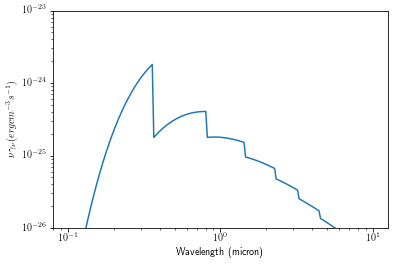

In [15]:
plt.loglog(3e14 / np.logspace(np.log10(3e13),
                              np.log10(3e15), 200), np.pi * np.array(test1))
plt.ylim(1e-26, 1e-23)
plt.ylabel(r'\nu \gamma_{\nu} (erg cm^{-3}s^{-1})')
plt.xlabel('Wavelength (micron)')

In [16]:
test2 = []
test3 = []
for nu in np.logspace(np.log10(3e13), np.log10(3e15), 400):
    test2.append(nu * 1 / 2 / np.pi * emissivity_free_free(1, 1, 1, 10000, nu))
    test3.append(nu * j_nu_fb(20, 1, nu, 10000, 1e4, 1e4))

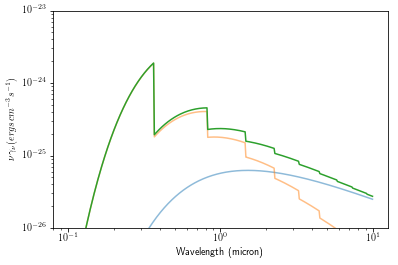

In [17]:
plt.loglog(3e14 / np.logspace(np.log10(3e13), np.log10(3e15), 400),
           np.array(test2), alpha=.5)
plt.loglog(3e14 / np.logspace(np.log10(3e13), np.log10(3e15), 400),
           np.pi * np.array(test3), alpha=.5)
plt.loglog(3e14 / np.logspace(np.log10(3e13), np.log10(3e15), 400),
           np.array(test2) + np.pi * np.array(test3))

plt.ylim(1e-26, 1e-23)
plt.ylabel(r'\nu \gamma_{\nu} (ergs \, cm^{-3}s^{-1})')
plt.xlabel('Wavelength (micron)')

In [18]:
import scipy.interpolate
nu_table=(10**14)*np.array([1E-26,1.23,2.47,3.70,4.93,6.17,7.40,8.64,9.87,11.10,12.34]) #10^14 Hz
nug_nu=(10**-12)*np.array([0,0.0373,0.242,0.679,1.37,2.33,3.55,5.01,6.69,8.59,10.6])

g_nu=nug_nu/nu_table
#Interpolate points on table.
gnu_interp=scipy.interpolate.interp1d(nu_table,g_nu,kind='cubic')

In [19]:
alpha_eff=0.838E-13 #cm^3 * s^-1
A_2= 8.23 #s^-1
q_p=2.51E-4 + 2.23E-4 #cm^3 * s^-1
q_e=0.22E-4 + 0.35E-4 #cm^3 * s^-1
nu_12=2*1.234E15

In [20]:
def gamma_nu(nu_arr, n_p, n_e):
    gammas=[]
    denom=1+((n_p*q_p+n_e*q_p)/A_2)
    for nu in nu_arr:
        if nu <= nu_12/2:
            g_nu=gnu_interp(nu)
            gammas.append((alpha_eff)*g_nu/denom)
        elif nu > nu_12/2:
            g_nu2=(nu/(nu_12-nu))*gnu_interp(nu_12-nu)
            gammas.append((alpha_eff)*g_nu2/denom)
    return gammas

In [21]:
nu_arr=np.logspace(np.log10(1.23E14),np.log10(2.467e15),200)
gamma_nu_arr=gamma_nu(nu_arr,0,0)

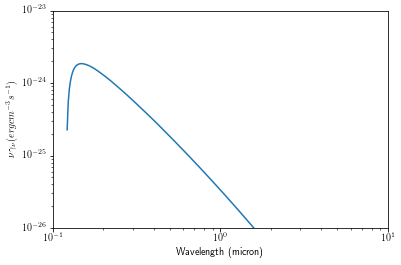

In [22]:
plt.loglog(3E14/np.logspace(np.log10(1.23e14),np.log10(2.467e15),200), nu_arr*gamma_nu_arr)
plt.ylabel(r'$\nu \gamma_{\nu} (erg cm^{-3}s^{-1})$')
plt.ylim(1e-26,1e-23)
plt.xlim(0.1,10)
plt.xlabel('Wavelength (micron)')

In [23]:
alpha_B = 2.6e-13 #cm^3 s^-1 for 10^4K only!

In [88]:
def nebular_continuum_emission(n, Z, nu, T, n_i, n_e, f_esc, N_LyC):
    j_fb = np.pi*j_nu_fb(n, Z, nu, T, n_i, n_e)
    j_ff = 1/2/np.pi*emissivity_free_free(Z, n_i, n_e, T, nu)
    j_2q = gamma_nu([nu], n_i, n_e)[0]
    return (j_fb + j_ff + j_2q) / alpha_B * (1 - f_esc) * N_LyC

In [90]:
nebular_continuum_emission(20, 1, 1e15, 10000, 1e4, 1e2, 0, 1e52)

mpf('5.9507588861014746e+25')

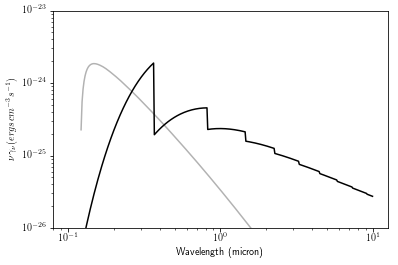

In [30]:
plt.loglog(3e14 / np.logspace(np.log10(3e13), np.log10(3e15), 400),
           np.array(test2) + np.pi * np.array(test3), 'k')
plt.loglog(3E14/np.logspace(np.log10(1.23e14),np.log10(2.467e15),200), nu_arr*gamma_nu_arr, 'k',alpha=.3)
plt.ylim(1e-26, 1e-23)
plt.ylabel(r'\nu \gamma_{\nu} (ergs \, cm^{-3}s^{-1})')
plt.xlabel('Wavelength (micron)')


In [42]:
import math

In [106]:
def hbeta_line_luminosity(fesc, N_LyC):
    return 4.78e-13 * (1-fesc) * N_LyC

def gaussian(wave, wave0, flux, sigma):
    return flux*np.exp(-(wave-wave0)**2/2/sigma**2)/(2*math.pi*sigma**2)**.5

def compute(fluxhbeta): 
    ratios=np.genfromtxt("ratios_10.dat")
    waves0, intensities, references=ratios[:,0], ratios[:,1], ratios[:,2]
    nu0 = 3e18 / waves0
    intensities *= references
    intensities *= fluxhbeta
    
    return waves0 / 10000, intensities / nu0

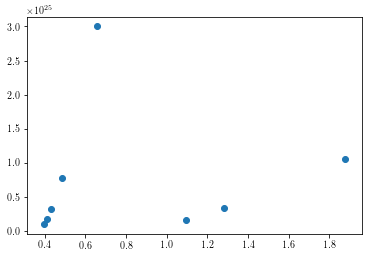

In [111]:
plt.scatter(compute(hbeta_line_luminosity(0,1e52))[0], compute(hbeta_line_luminosity(0,1e52))[1])

In [117]:
nus = np.concatenate(([3e14 / compute(hbeta_line_luminosity(0,1e52))[0],np.logspace(np.log10(1.23e14),np.log10(2.467e15),400)]))

In [122]:
len(outlines)

408

In [118]:
out = [nebular_continuum_emission(20, 1, i, 10000, 1e4, 1e2, 0, 1e52) for i in nus]

In [119]:
outlines = np.concatenate((compute(hbeta_line_luminosity(0,1e52))[1], np.zeros(400)))

In [ ]:
np.argsort(nus)

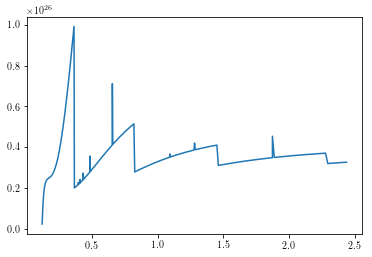

In [126]:
plt.plot((3e14/nus)[np.argsort(nus)], (out + outlines)[np.argsort(nus)])


In [127]:
np.savetxt('plot.txt', [(3e14/nus)[np.argsort(nus)],(out + outlines)[np.argsort(nus)]])

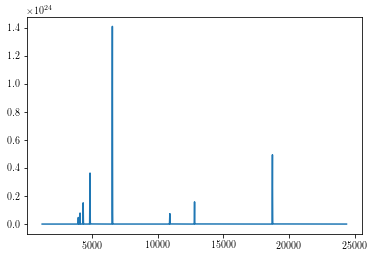

In [97]:
plt.plot(3e14/np.logspace(np.log10(1.23e14),np.log10(2.467e15),400000)*10000, compute(hbeta_line_luminosity(0, 1e52), 3e14/np.logspace(np.log10(1.23e14),np.log10(2.467e15),400000)*10000, 20))

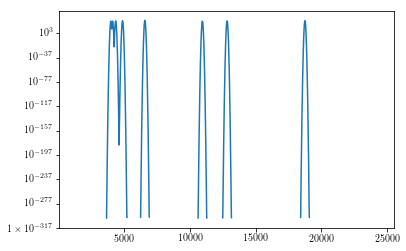

In [102]:
#plt.semilogy(3e14/np.logspace(np.log10(1.23e14),np.log10(2.467e15),400), out)
plt.semilogy(3e14/np.logspace(np.log10(1.23e14),np.log10(2.467e15),400000)*10000, compute(hbeta_line_luminosity(0, 1e52), 3e14/np.logspace(np.log10(1.23e14),np.log10(2.467e15),400000)*10000, 20))